# Import

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as dset
from torch.utils.data import DataLoader

from tqdm import tqdm

In [5]:
torch.cuda.is_available()

True

# Model

In [6]:
class FCBlock(nn.Module):
    def __init__(self, _in, _out):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(_in, _out, bias=True),
            nn.LeakyReLU(0.2, inplace=True)
        )

        self._init_weights(self.layers)
    
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            nn.init.normal_(module.weight.data, 0.0, 0.02)
            if module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.BatchNorm1d):
            nn.init.normal_(module.weight.data, 1.0, 0.02)
            nn.init.constant_(module.bias.data, 0)


    def forward(self, x):
        return self.layers(x)

In [7]:
z_dim = 100

class Generator(nn.Module):
    def __init__(self, in_dim, out_dim, hidden_dim):
        super().__init__()
        self.input_layer = nn.Sequential(
            FCBlock(in_dim, hidden_dim)
        )
        self.hidden_layers = nn.Sequential(
            FCBlock(hidden_dim, 2 * hidden_dim),
            FCBlock(2 * hidden_dim, 4 * hidden_dim),
        )
        self.output_layer = nn.Sequential(
            nn.Linear(4 * hidden_dim, out_dim),
            nn.Tanh()
        )

    def forward(self, x):
        out = self.input_layer(x)
        out = self.hidden_layers(out)
        out = self.output_layer(out)

        return out

In [8]:
class Discriminator(nn.Module):
    def __init__(self, in_dim, out_dim, hidden_dim):
        super().__init__()
        self.input_layer = FCBlock(in_dim, 4 * hidden_dim)
        
        self.hidden_layers = nn.Sequential(
            FCBlock(4 * hidden_dim, 2 * hidden_dim),
            FCBlock(2 * hidden_dim, hidden_dim)
        )
        self.output_layer = nn.Sequential(
            nn.Linear(hidden_dim, out_dim),
            nn.Sigmoid()
        )
        

    def forward(self, x):
        out = self.input_layer(x)
        out = self.hidden_layers(out)
        out = self.output_layer(out)

        return out
        

# Dataset

In [9]:
dataset = dset.MNIST(
    root="./data/",
    train=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])
    ]),
    download=True
)

In [14]:
BATCH_SIZE = 32

data_loader = DataLoader(
    dataset=dataset,
    batch_size=BATCH_SIZE,
    num_workers=8,
    shuffle=True,
    drop_last=True
)

# Train

In [15]:
G = Generator(in_dim=z_dim, out_dim=784, hidden_dim=128).to("cuda")
D = Discriminator(in_dim=784, out_dim=1, hidden_dim=128).to("cuda") 

criterion = nn.BCELoss().cuda()
D_optimizer = optim.Adam(params=D.parameters(), lr=2e-4)
G_optimizer = optim.Adam(params=G.parameters(), lr=2e-4)

K = 1
epochs = 100

In [16]:
total_batch = len(data_loader)
img_list = []

for epoch in tqdm(range(epochs)):
    avgLoss_D_real = 0
    avgLoss_D_fake = 0
    avgLoss_G = 0

    for X, Y in data_loader:
        X = X.view(-1, 784)
        X = X.cuda()

        for _ in range(K):
            noise = torch.randn(BATCH_SIZE, z_dim, device="cuda")
            fake = G(noise)

            predict = D(X).view(-1)

            real_label = torch.ones((BATCH_SIZE,), dtype=torch.float, device="cuda")
            lossD_real = criterion(predict, real_label.detach())    

            predict = D(fake.detach()).view(-1)

            fake_label = torch.zeros((BATCH_SIZE,), dtype=torch.float, device="cuda")
            lossD_fake = criterion(predict, fake_label.detach())

            lossD = (lossD_real + lossD_fake) / 2

            D.zero_grad()
            lossD.backward()
            D_optimizer.step()

        noise = torch.randn(BATCH_SIZE, z_dim, device="cuda")
        fake = G(noise)
        real_label_G = torch.zeros((BATCH_SIZE,), dtype=torch.float, device="cuda")

        predict = D(fake).view(-1)
        lossG = criterion(1 - predict, real_label_G.detach())

        G.zero_grad()
        lossG.backward()
        G_optimizer.step()

        avgLoss_D_real += lossD_real.mean().item() / total_batch
        avgLoss_D_fake += lossD_fake.mean().item() / total_batch
        avgLoss_G += lossG.mean().item() / total_batch
    
    if (epoch+1) % 1 == 0:
        print(f"epoch: {epoch+1:3d}\tloss D real: {avgLoss_D_real:.5f}\tloss D fake: {avgLoss_D_fake:.5f}\tloss G: {avgLoss_G:.5f}")
        img_list.append(fake[0])



  1%|          | 1/100 [00:10<17:31, 10.62s/it]

epoch:   1	loss D real: 0.44312	loss D fake: 0.52166	loss G: 2.16851


  2%|▏         | 2/100 [00:20<17:00, 10.41s/it]

epoch:   2	loss D real: 0.51678	loss D fake: 0.42873	loss G: 2.03105


  3%|▎         | 3/100 [00:31<17:12, 10.65s/it]

epoch:   3	loss D real: 0.29944	loss D fake: 0.19996	loss G: 3.26028


  4%|▍         | 4/100 [00:41<16:31, 10.33s/it]

epoch:   4	loss D real: 0.29859	loss D fake: 0.21535	loss G: 2.85054


  5%|▌         | 5/100 [00:51<16:05, 10.16s/it]

epoch:   5	loss D real: 0.28084	loss D fake: 0.19477	loss G: 3.01753


  6%|▌         | 6/100 [01:02<16:07, 10.30s/it]

epoch:   6	loss D real: 0.32074	loss D fake: 0.25351	loss G: 2.51439


  7%|▋         | 7/100 [01:12<16:06, 10.39s/it]

epoch:   7	loss D real: 0.34569	loss D fake: 0.28637	loss G: 2.43168


  8%|▊         | 8/100 [01:23<15:56, 10.40s/it]

epoch:   8	loss D real: 0.36088	loss D fake: 0.30904	loss G: 2.25669


  9%|▉         | 9/100 [01:32<15:27, 10.19s/it]

epoch:   9	loss D real: 0.35092	loss D fake: 0.29740	loss G: 2.29129


 10%|█         | 10/100 [01:43<15:28, 10.32s/it]

epoch:  10	loss D real: 0.37165	loss D fake: 0.32191	loss G: 2.15251


 11%|█         | 11/100 [01:53<15:13, 10.26s/it]

epoch:  11	loss D real: 0.38633	loss D fake: 0.33907	loss G: 2.06487


 12%|█▏        | 12/100 [02:04<15:11, 10.36s/it]

epoch:  12	loss D real: 0.40757	loss D fake: 0.36082	loss G: 1.89829


 13%|█▎        | 13/100 [02:14<14:53, 10.27s/it]

epoch:  13	loss D real: 0.42871	loss D fake: 0.39050	loss G: 1.80604


 14%|█▍        | 14/100 [02:24<14:36, 10.19s/it]

epoch:  14	loss D real: 0.42872	loss D fake: 0.38886	loss G: 1.78917


 15%|█▌        | 15/100 [02:34<14:27, 10.21s/it]

epoch:  15	loss D real: 0.44303	loss D fake: 0.40451	loss G: 1.72310


 16%|█▌        | 16/100 [02:44<14:25, 10.31s/it]

epoch:  16	loss D real: 0.45128	loss D fake: 0.41826	loss G: 1.65617


 17%|█▋        | 17/100 [02:55<14:30, 10.49s/it]

epoch:  17	loss D real: 0.45759	loss D fake: 0.42835	loss G: 1.61472


 18%|█▊        | 18/100 [03:06<14:12, 10.40s/it]

epoch:  18	loss D real: 0.46185	loss D fake: 0.43428	loss G: 1.61002


 19%|█▉        | 19/100 [03:15<13:45, 10.19s/it]

epoch:  19	loss D real: 0.46848	loss D fake: 0.44032	loss G: 1.56890


 20%|██        | 20/100 [03:26<13:44, 10.31s/it]

epoch:  20	loss D real: 0.47052	loss D fake: 0.44027	loss G: 1.56536


 21%|██        | 21/100 [03:37<13:45, 10.45s/it]

epoch:  21	loss D real: 0.47445	loss D fake: 0.44848	loss G: 1.53413


 22%|██▏       | 22/100 [03:47<13:32, 10.41s/it]

epoch:  22	loss D real: 0.48242	loss D fake: 0.45534	loss G: 1.51500


 23%|██▎       | 23/100 [03:57<13:09, 10.25s/it]

epoch:  23	loss D real: 0.48756	loss D fake: 0.46117	loss G: 1.47622


 24%|██▍       | 24/100 [04:07<13:06, 10.35s/it]

epoch:  24	loss D real: 0.48677	loss D fake: 0.46343	loss G: 1.46142


 25%|██▌       | 25/100 [04:18<12:52, 10.30s/it]

epoch:  25	loss D real: 0.49116	loss D fake: 0.46789	loss G: 1.46178


 26%|██▌       | 26/100 [04:28<12:54, 10.47s/it]

epoch:  26	loss D real: 0.49595	loss D fake: 0.47658	loss G: 1.42489


 27%|██▋       | 27/100 [04:38<12:32, 10.31s/it]

epoch:  27	loss D real: 0.49889	loss D fake: 0.47796	loss G: 1.43195


 28%|██▊       | 28/100 [04:48<12:14, 10.20s/it]

epoch:  28	loss D real: 0.49603	loss D fake: 0.47627	loss G: 1.43977


 29%|██▉       | 29/100 [04:59<12:09, 10.28s/it]

epoch:  29	loss D real: 0.50213	loss D fake: 0.48299	loss G: 1.42216


 30%|███       | 30/100 [05:09<11:57, 10.24s/it]

epoch:  30	loss D real: 0.50483	loss D fake: 0.48492	loss G: 1.41524


 31%|███       | 31/100 [05:20<12:01, 10.46s/it]

epoch:  31	loss D real: 0.50681	loss D fake: 0.48577	loss G: 1.38927


 32%|███▏      | 32/100 [05:30<11:41, 10.31s/it]

epoch:  32	loss D real: 0.50734	loss D fake: 0.48931	loss G: 1.39331


 33%|███▎      | 33/100 [05:40<11:20, 10.15s/it]

epoch:  33	loss D real: 0.50806	loss D fake: 0.48726	loss G: 1.40954


 34%|███▍      | 34/100 [05:50<11:17, 10.27s/it]

epoch:  34	loss D real: 0.50914	loss D fake: 0.49174	loss G: 1.38454


 35%|███▌      | 35/100 [06:01<11:19, 10.46s/it]

epoch:  35	loss D real: 0.50770	loss D fake: 0.49096	loss G: 1.37592


 36%|███▌      | 36/100 [06:12<11:09, 10.46s/it]

epoch:  36	loss D real: 0.51187	loss D fake: 0.49448	loss G: 1.36695


 37%|███▋      | 37/100 [06:22<10:51, 10.34s/it]

epoch:  37	loss D real: 0.51019	loss D fake: 0.49226	loss G: 1.38351


 38%|███▊      | 38/100 [06:32<10:45, 10.41s/it]

epoch:  38	loss D real: 0.51536	loss D fake: 0.49783	loss G: 1.36488


 39%|███▉      | 39/100 [06:43<10:34, 10.41s/it]

epoch:  39	loss D real: 0.51480	loss D fake: 0.49813	loss G: 1.35445


 40%|████      | 40/100 [06:53<10:25, 10.43s/it]

epoch:  40	loss D real: 0.51264	loss D fake: 0.49411	loss G: 1.37789


 41%|████      | 41/100 [07:03<10:06, 10.28s/it]

epoch:  41	loss D real: 0.51478	loss D fake: 0.49568	loss G: 1.35198


 42%|████▏     | 42/100 [07:13<09:53, 10.24s/it]

epoch:  42	loss D real: 0.51385	loss D fake: 0.49761	loss G: 1.35669


 43%|████▎     | 43/100 [07:24<09:52, 10.39s/it]

epoch:  43	loss D real: 0.51491	loss D fake: 0.49692	loss G: 1.35345


 44%|████▍     | 44/100 [07:34<09:44, 10.43s/it]

epoch:  44	loss D real: 0.51604	loss D fake: 0.49842	loss G: 1.35785


 45%|████▌     | 45/100 [07:45<09:34, 10.44s/it]

epoch:  45	loss D real: 0.51296	loss D fake: 0.49509	loss G: 1.35837


 46%|████▌     | 46/100 [07:55<09:14, 10.27s/it]

epoch:  46	loss D real: 0.51696	loss D fake: 0.49841	loss G: 1.35334


 46%|████▌     | 46/100 [07:55<09:18, 10.34s/it]


KeyboardInterrupt: 

# Visualization

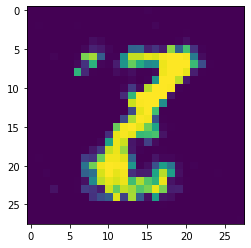

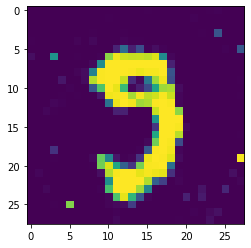

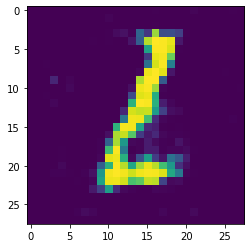

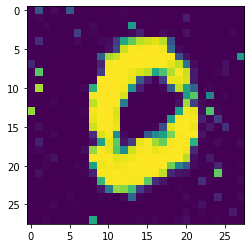

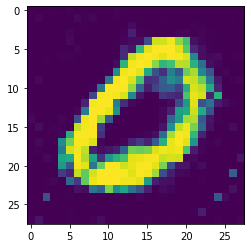

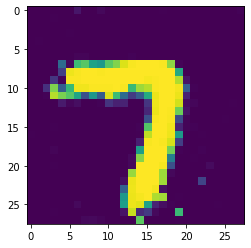

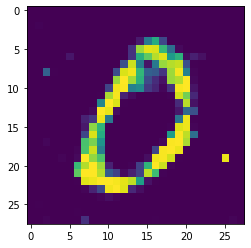

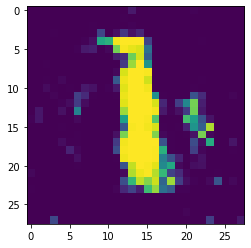

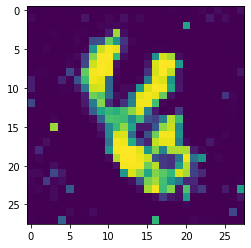

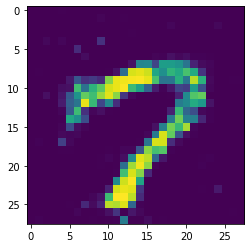

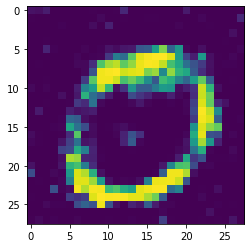

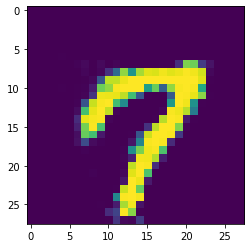

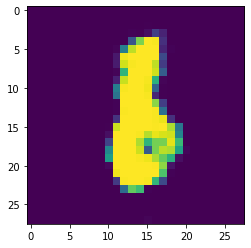

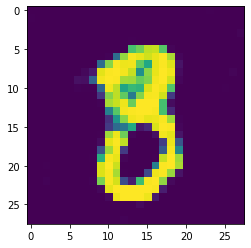

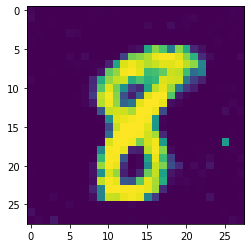

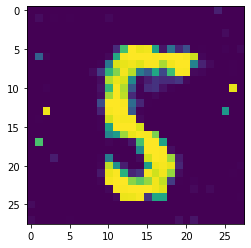

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline

for i, img in enumerate(img_list[30:]):
    img = img.detach().cpu().numpy()
    img = img.reshape(28, 28)
    plt.figure(i)
    plt.imshow(img)


In [24]:
img_list[10]

tensor([-1.5649e+00, -3.1037e-01, -4.6028e-01,  7.3794e-01,  2.2419e-01,
        -4.6629e-01,  8.8602e-01, -4.5785e-01, -3.6058e-01,  5.2151e-01,
        -9.5676e-01,  9.8635e-02, -2.2184e-03,  9.4041e-01, -6.6961e-01,
         6.5446e-01,  3.5542e-02,  1.2562e+00,  6.6975e-01, -9.6971e-02,
        -4.4120e-01,  2.1790e-03, -4.2388e-01,  1.3675e-01, -2.5530e-01,
         9.5540e-01,  4.3439e-01,  3.5375e-01,  9.8293e-01,  1.7928e-01,
         5.6655e-01, -1.2469e+00, -1.4384e-01,  1.2059e+00, -4.3941e-01,
         1.2700e+00, -4.7460e-01,  5.2119e-01, -3.7073e-01, -9.3441e-02,
        -8.6915e-01, -2.0542e-01, -5.1061e-01,  2.2877e-01,  3.7672e-01,
         8.7237e-01,  6.1279e-01,  2.2675e-01,  7.9403e-01,  1.2734e+00,
        -2.5567e-01,  3.3625e-01, -5.7791e-01, -3.4514e-01, -4.6474e-01,
        -3.0294e-02,  6.1178e-01,  1.1928e-01, -5.8744e-01,  1.9188e-02,
        -8.6125e-01, -2.4023e-01, -1.1981e-02,  8.5774e-01, -9.0545e-01,
         3.0869e-01, -3.1482e-02,  1.2484e-02, -1.9